## Load Libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2 as cv
import numpy as np
import torchvision.transforms as transforms
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch

## Creating a custom dataset loader
We will use 2000 images as test dataset. First 1000 images of cats and last 1000 images of dogs.
#Remaining images will be used for training

In [2]:
class custom_dataset_class(Dataset):
    def __init__(self, data_path, train = True, transform = None):
        self.data_paths = data_path
        if train:
            self.data_list = os.listdir(data_path)[1001:-1000]
        else:
            self.data_list = os.listdir(data_path)[:1000] + os.listdir(data_path)[-100:]
        self.transform = transform
        self.uniform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
        
    def __len__(self):
        return(len(self.data_list))
    
    def get_labels(self, filename):
        if filename[0:3] == "cat":
            return 0
        else:
            return 1
        
    def __getitem__(self,idx):
        file_path = os.path.join(self.data_paths,self.data_list[idx])
        image = Image.open(file_path)
        #image_unf = self.uniform(image)
        if self.transform:
            image_unf = self.transform(image)
        return image_unf,self.get_labels(self.data_list[idx])

Addind the exact transforms needed for restnet18 model

In [3]:
#t1=transforms.RandomPerspective(distortion_scale=0.2, p=0.2)
#t2=transforms.RandomAffine(degrees=90, fill=(236, 209, 239), translate=(0.1, 0.1), scale=(0.8, 0.9))
#t3=transforms.RandomRotation(degrees=(0, 180))
#t4 = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])

#compt = transforms.Compose([t1,t2,t3,t4])
train_cat_dog_dataset = custom_dataset_class(data_path="./Data/dogs-vs-cats/train/train/", transform=transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

test_cat_dog_dataset = custom_dataset_class(data_path="./Data/dogs-vs-cats/train/train/", train=False, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]))

In [4]:
print(len(train_cat_dog_dataset))
print(len(test_cat_dog_dataset))

22999
1100


Text(0.5, 1.0, '1')

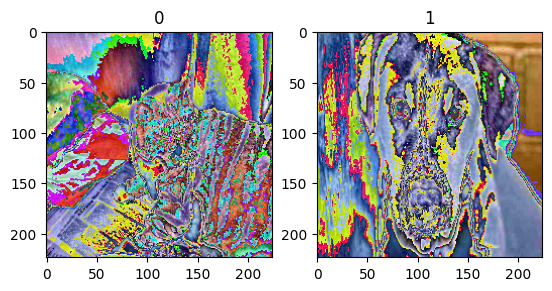

In [5]:
# Let us see a cat and dog to check if images are loaded correcly

img1 = train_cat_dog_dataset[999]
img2 = train_cat_dog_dataset[14500]

fig = plt.figure()
gs = gridspec.GridSpec(1,2)
ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(transforms.functional.to_pil_image(img1[0]))
ax1.set_title(img1[1])

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(transforms.functional.to_pil_image(img2[0]))
ax2.set_title(img2[1])

In [6]:
train_dataloader = DataLoader(
    train_cat_dog_dataset,
    batch_size=50,
    shuffle=True)

test_dataloader = DataLoader(
    test_cat_dog_dataset,
    batch_size=50,
    shuffle=True)

## Checking for GPU

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading pre-trained model

We will load a pre-trained inception model. Will use the entire network as such except the last linear layer which we will train to classifiy images as cats or dogs.

In [8]:
model = models.resnet18(pretrained=True)

C:\Users\Ashutosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashutosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
for name, param in model.named_parameters():
    print(f"{name:60} -> {tuple(param.shape)}")

conv1.weight                                                 -> (64, 3, 7, 7)
bn1.weight                                                   -> (64,)
bn1.bias                                                     -> (64,)
layer1.0.conv1.weight                                        -> (64, 64, 3, 3)
layer1.0.bn1.weight                                          -> (64,)
layer1.0.bn1.bias                                            -> (64,)
layer1.0.conv2.weight                                        -> (64, 64, 3, 3)
layer1.0.bn2.weight                                          -> (64,)
layer1.0.bn2.bias                                            -> (64,)
layer1.1.conv1.weight                                        -> (64, 64, 3, 3)
layer1.1.bn1.weight                                          -> (64,)
layer1.1.bn1.bias                                            -> (64,)
layer1.1.conv2.weight                                        -> (64, 64, 3, 3)
layer1.1.bn2.weight                           

In [10]:

# Freeze all layers if using as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (512 input features)
model.fc = nn.Linear(512, 2)

model = model.to(device)

In [11]:
for name, param in model.named_parameters():
    print(f"{name:60} -> {tuple(param.shape)}")
    print(param.requires_grad)

conv1.weight                                                 -> (64, 3, 7, 7)
False
bn1.weight                                                   -> (64,)
False
bn1.bias                                                     -> (64,)
False
layer1.0.conv1.weight                                        -> (64, 64, 3, 3)
False
layer1.0.bn1.weight                                          -> (64,)
False
layer1.0.bn1.bias                                            -> (64,)
False
layer1.0.conv2.weight                                        -> (64, 64, 3, 3)
False
layer1.0.bn2.weight                                          -> (64,)
False
layer1.0.bn2.bias                                            -> (64,)
False
layer1.1.conv1.weight                                        -> (64, 64, 3, 3)
False
layer1.1.bn1.weight                                          -> (64,)
False
layer1.1.bn1.bias                                            -> (64,)
False
layer1.1.conv2.weight                                

## Training Loop

In [13]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
        

num_epoch = 10

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    batch = 0
    print("iteration epoch = {0}".format(epoch))
    for img, label in train_dataloader:
        
        #for name, param in model.named_parameters():
            #print(f"{name}: requires_grad={param.requires_grad}")
        
        batch += 1
        #print("iteration epoch = {0} and batch = {1}".format(epoch,batch))
        temp_image = img.to(device)
        temp_label = label.to(device)
        
        outputs = model(temp_image)
        
        loss = criterion(outputs,temp_label)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        # 4. Track stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += temp_label.size(0)
        correct += (predicted == temp_label).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epoch}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")


iteration epoch = 0


KeyboardInterrupt: 

## Validation

In [ ]:
model.eval()
val_correct = 0
val_total = 0

with torch.no_grad():
    for img, label in test_dataloader:
        temp_image = img.to(device)
        temp_label = label.to(device)
        
        outputs = model(img)
        loss = criterion(outputs, temp_label)
        __, predicted = torch.max(outputs,1)
        val_total += label.size(0)
        val_correct += (predicted == temp_label).sum().item()
        
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc:.4f}")

In [ ]:
torch.save(model.state_dict(), "pre_trained_weights_restnet.pth")